### Presenting a solution to get into top 7% of leaderboard using Support Vector Classifier with an accuracy score of 0.81063

<center><img src="https://media3.s-nbcnews.com/j/newscms/2019_41/3044956/191009-cooking-vegetables-al-1422_ae181a762406ae9dce02dd0d5453d1ba.nbcnews-fp-1200-630.jpg" alt="Cooking Image from Google"></center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import json
import re
import nltk
import zipfile

from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='../data/external/')
    with zipfile.ZipFile("../data/external/corpora/wordnet.zip","r") as z:
        z.extractall("../data/external/corpora")
    nltk.data.path.append('../data/external/')

# Now you can import the NLTK resources as usual
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to ../data/external/...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
for t in ['train','test']:
    with zipfile.ZipFile("../data/raw/{}.json.zip".format(t),"r") as z:
        z.extractall("../data/interim/")
    
with open('../data/interim/train.json') as data_file:    
    data = json.load(data_file)
    
with open('../data/interim/test.json') as test_file:
    test = json.load(test_file)

In [4]:
df = pd.DataFrame(data)
test_df = pd.DataFrame(test)

test_ids = test_df['id']

df.head()

id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...

# EDA

In [5]:
(df.isnull().sum() / len(df))*100 # No null values in train

id             0.0
cuisine        0.0
ingredients    0.0
dtype: float64

In [6]:
(test_df.isnull().sum() / len(test_df))*100 # No null values in test

id             0.0
ingredients    0.0
dtype: float64

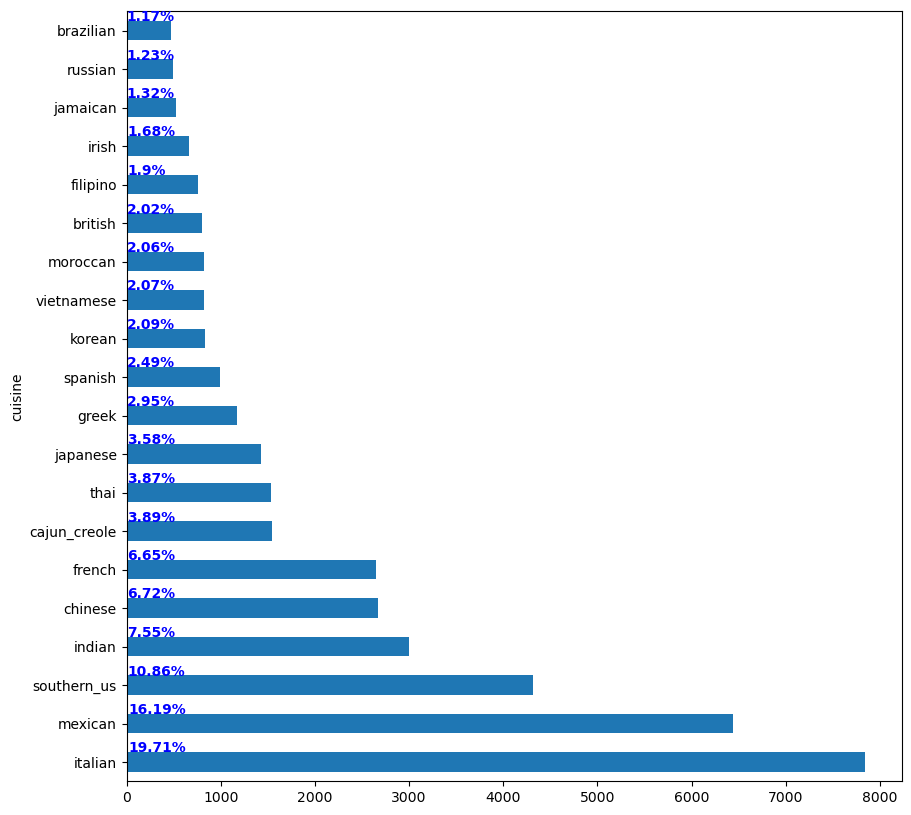

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
per_vals = round(df["cuisine"].value_counts(normalize=True)*100, 2)
for i, v in enumerate(per_vals):
    ax.text(v + 3, i + .25, str(v)+"%", color='blue', fontweight='bold')
df["cuisine"].value_counts().plot.barh(ax = ax)
plt.show()

In [8]:
fig, ax = plt.subplots(figsize=(22,7))
extensive_ing_list = []
for x in df['ingredients']:
    for y in x:
        extensive_ing_list.append(y)
        
extensive_ing_list = pd.Series(extensive_ing_list)
extensive_ing_list.value_counts().sort_values(ascending=False).head(30).plot.bar(ax = ax)

<Axes: >

### Creating ingredients per cuisine

In [9]:
cuisine = df["cuisine"].unique()

all_cus = dict()
for cs in cuisine:
    i = []
    for ing_list in df[df['cuisine']==cs]['ingredients']:
        for ing in ing_list:
            i.append(ing)
    all_cus[cs] = i

all_cus.keys()

dict_keys(['greek', 'southern_us', 'filipino', 'indian', 'jamaican', 'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai', 'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese', 'irish', 'korean', 'moroccan', 'russian'])

#### 25 MOST USED INGREDIENTS- CUISINE WISE

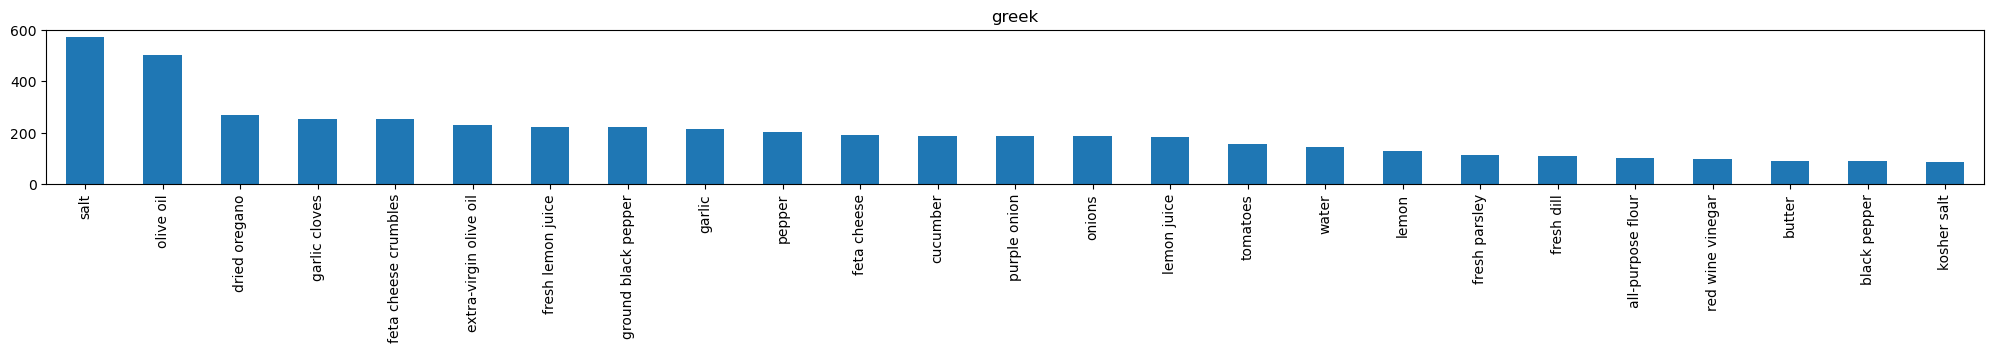

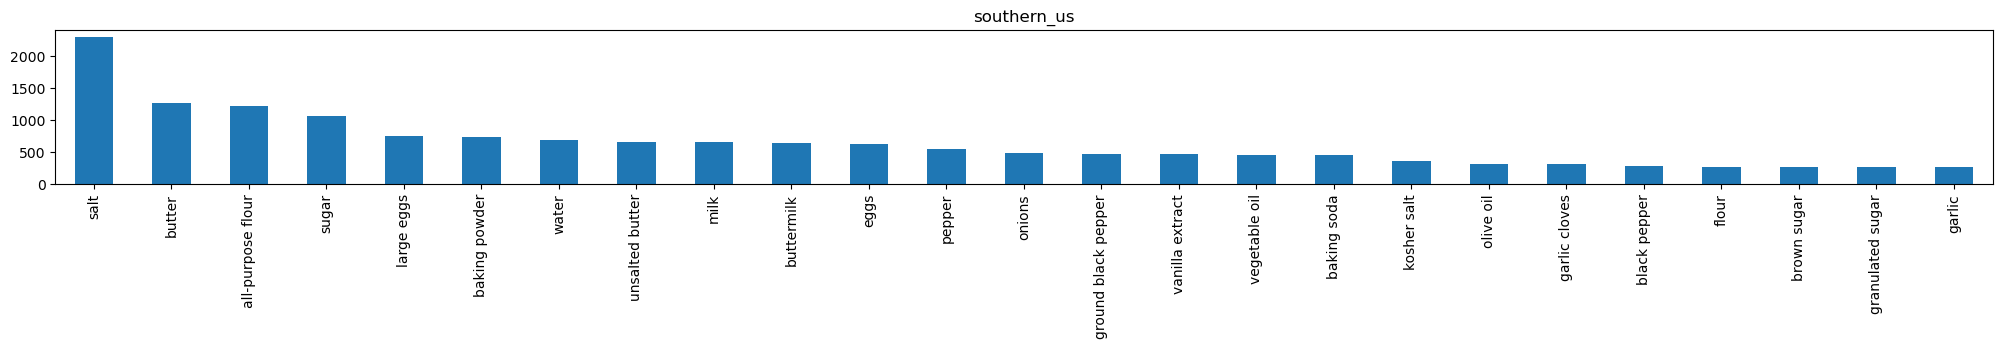

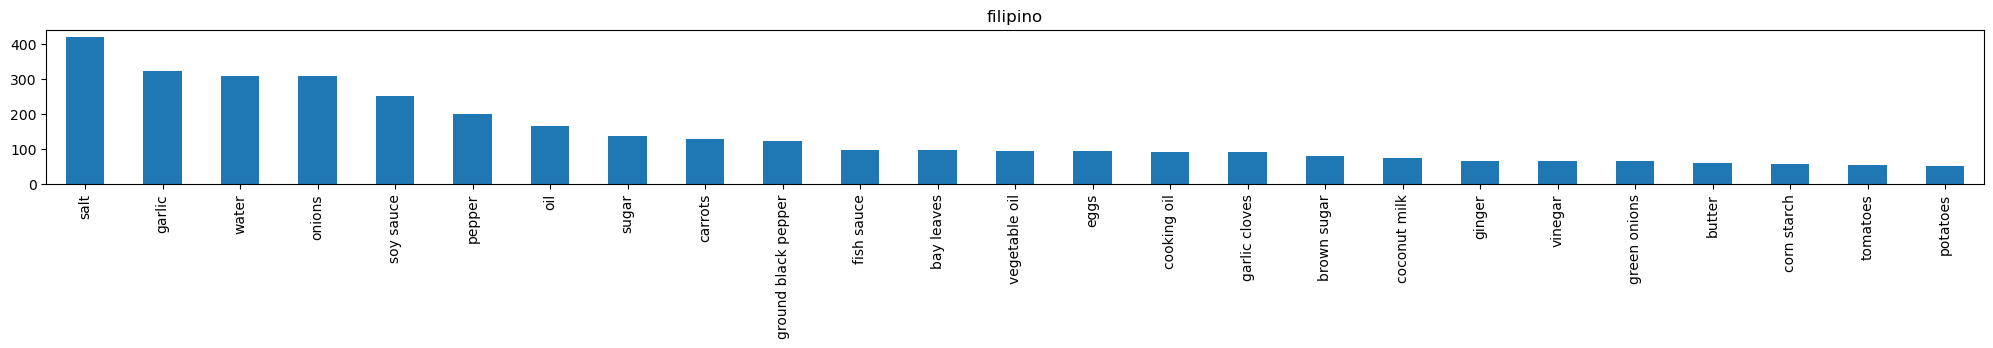

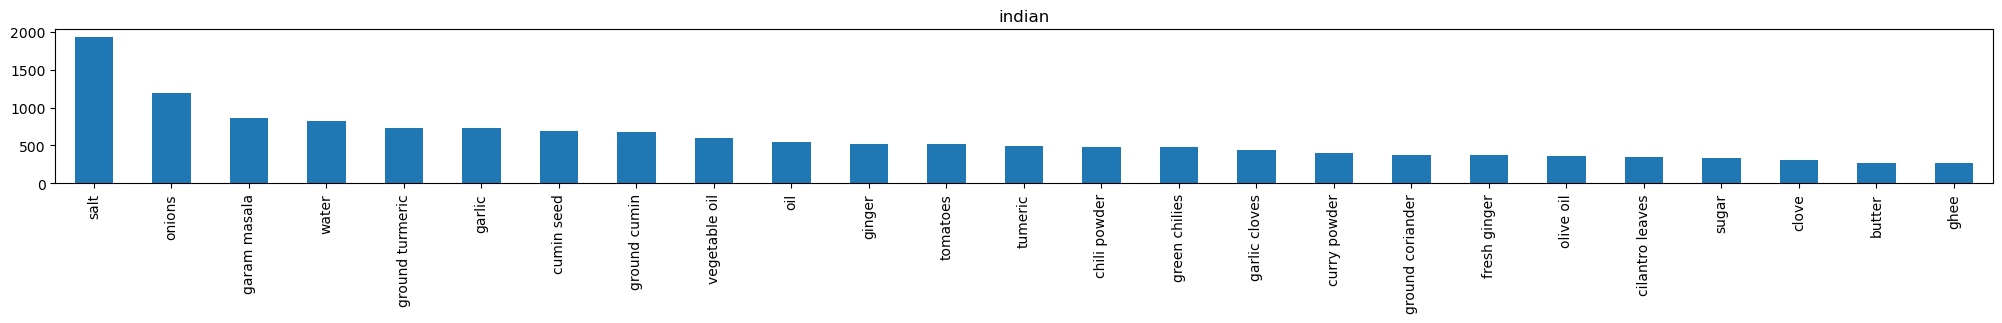

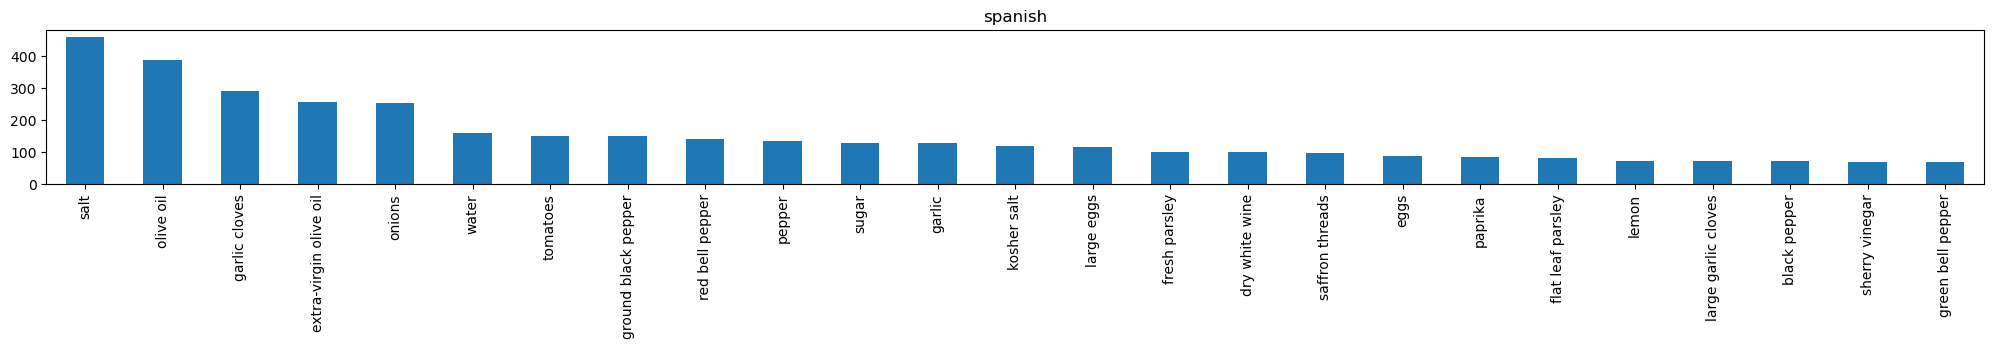

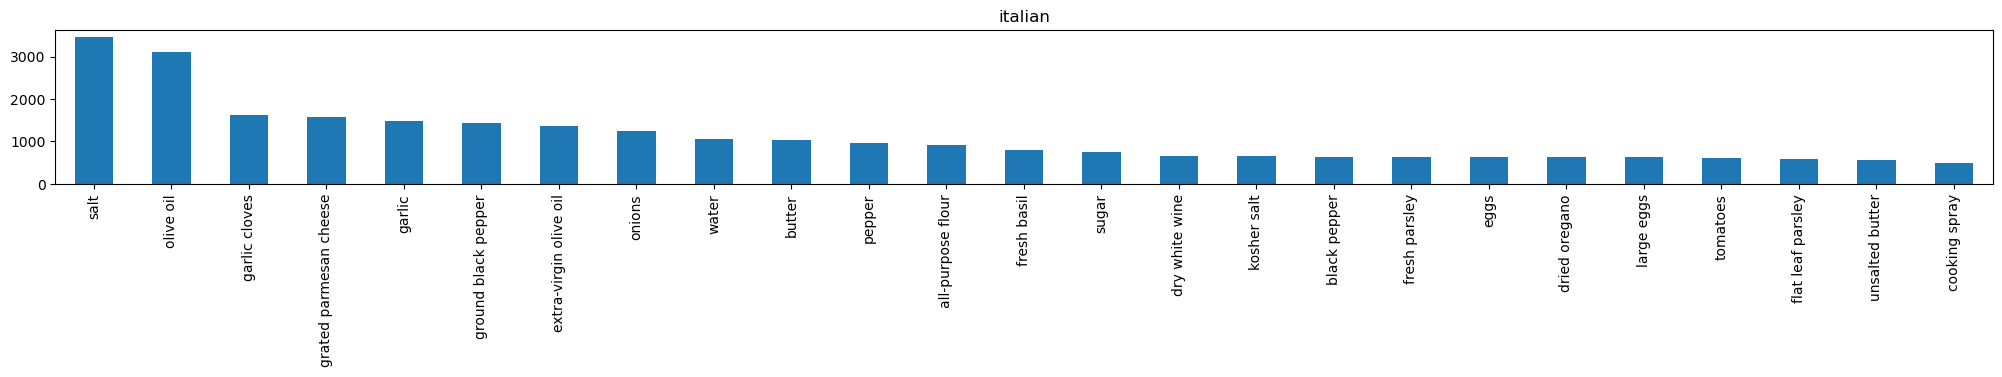

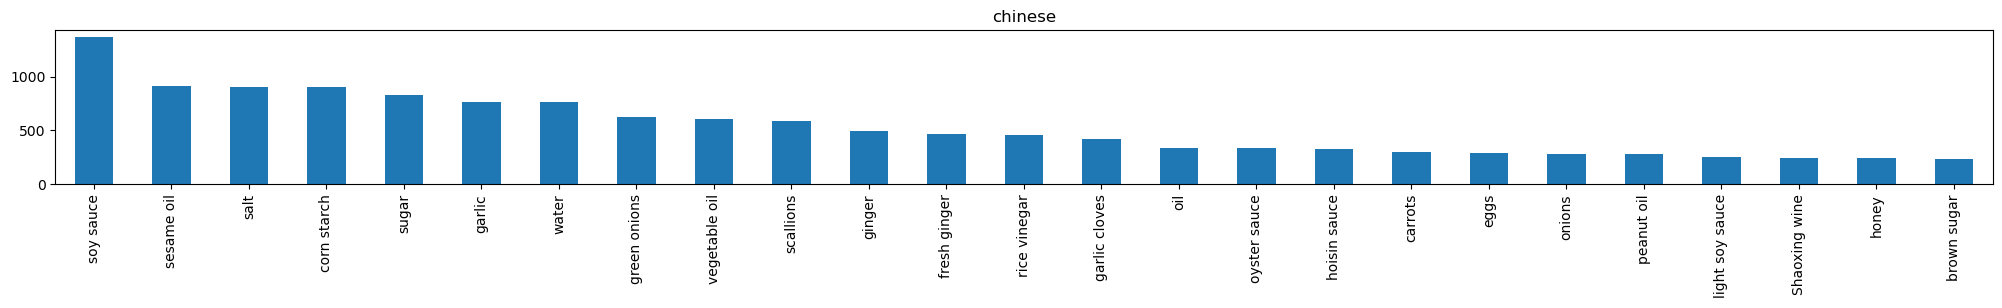

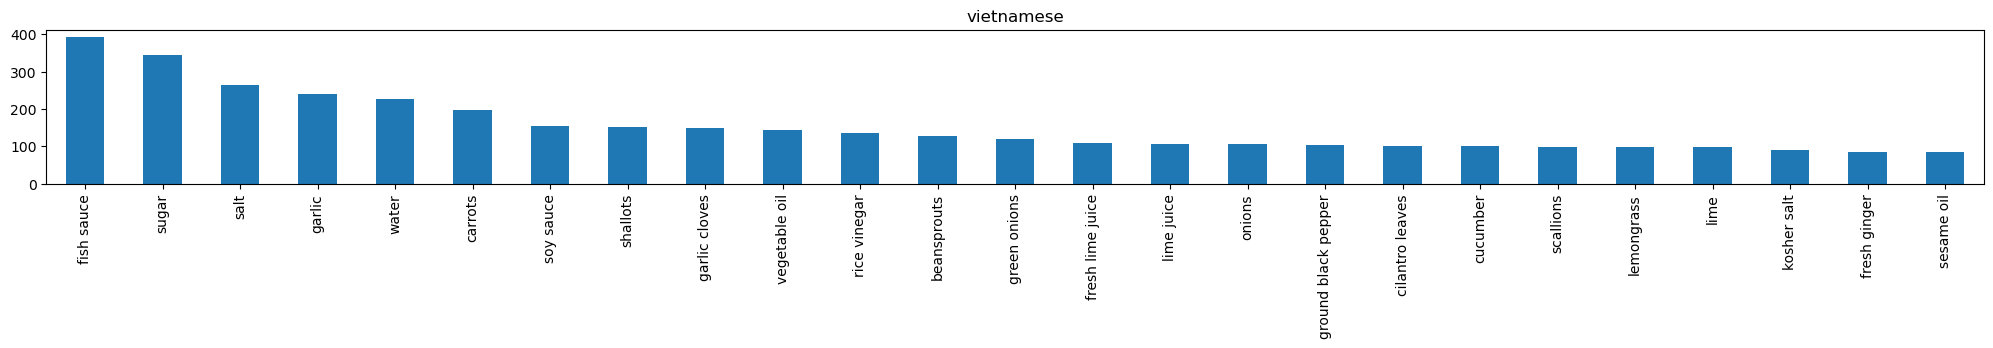

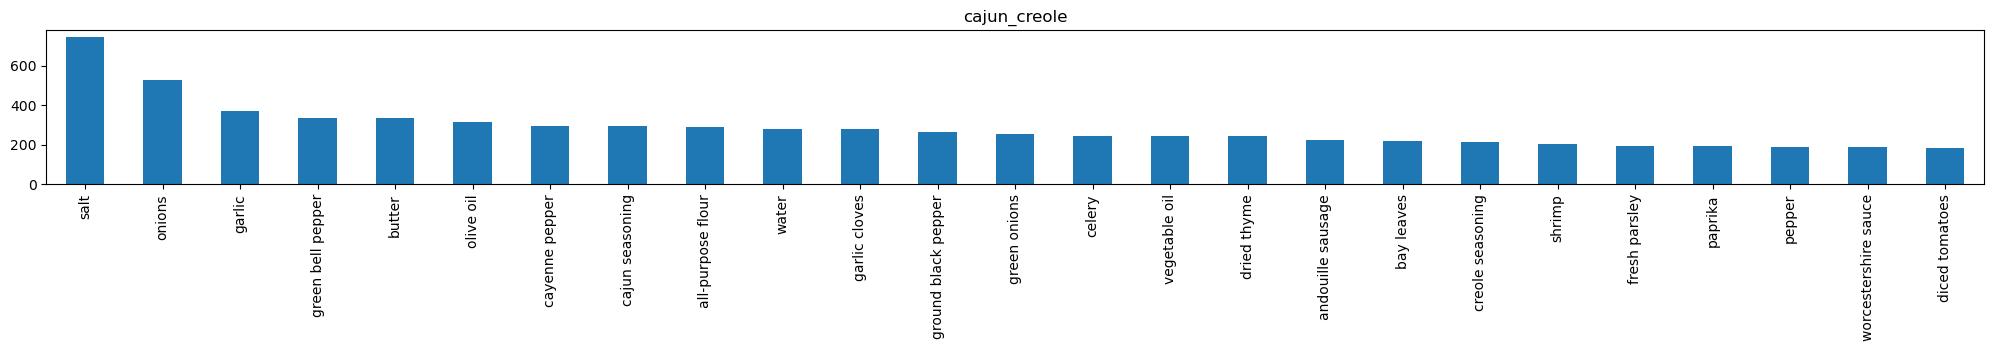

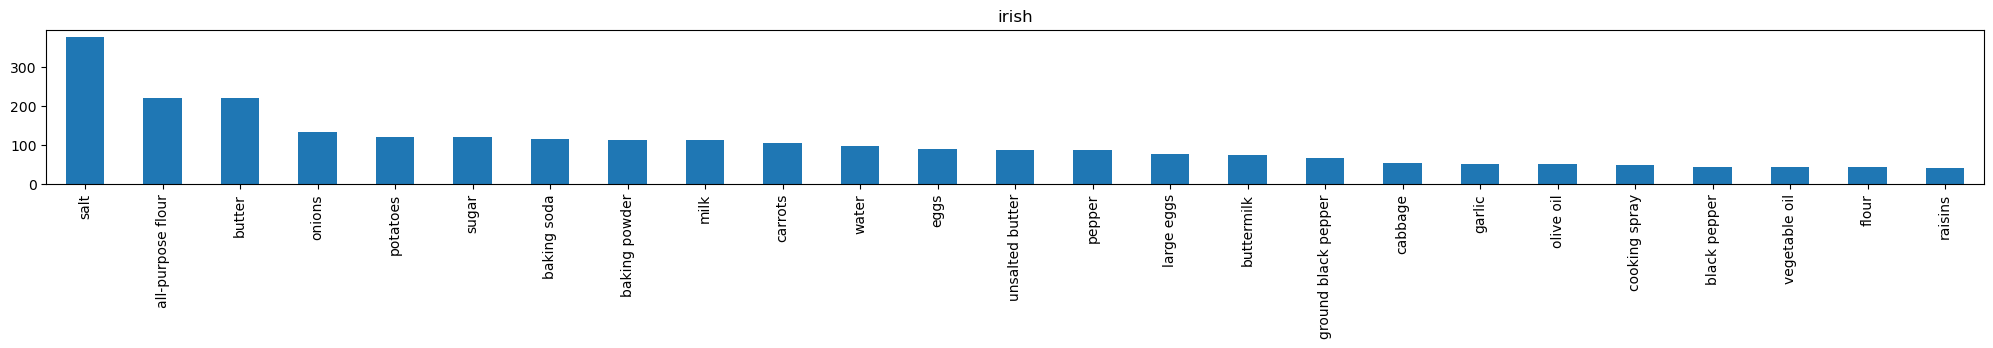

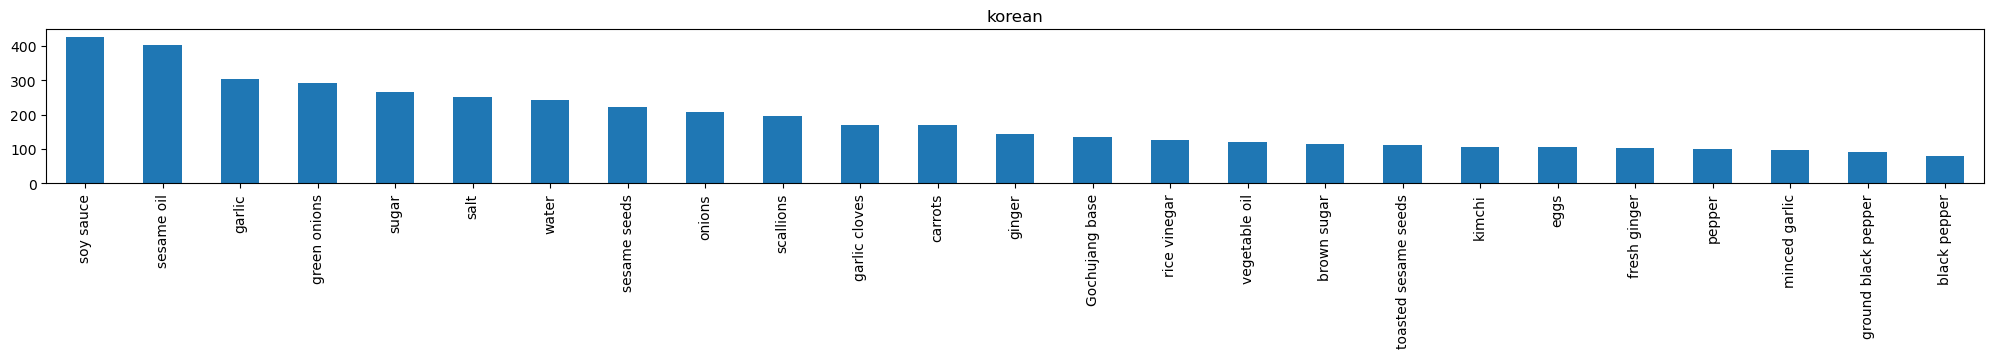

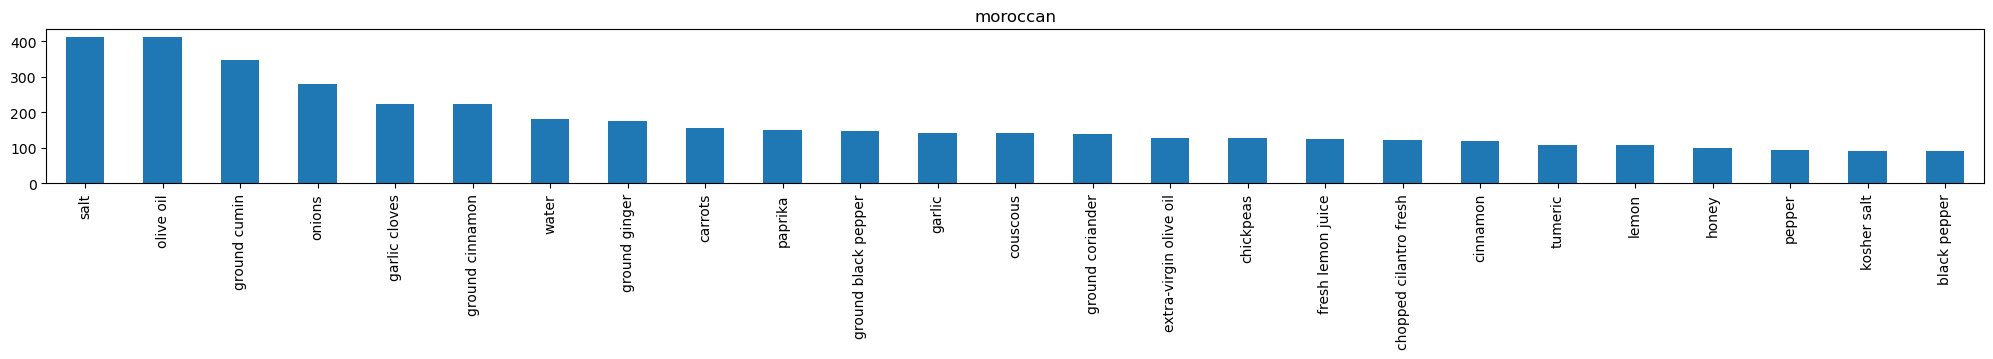

In [10]:
for key in all_cus.keys():
    fig, ax = plt.subplots(figsize=(25,2))
    pd.Series(all_cus[key]).value_counts().head(25).plot.bar(ax=ax, title=key)
    plt.show()

#### 25 LEAST USED INGREDIENTS- CUISINE WISE

In [11]:
# for key in all_cus.keys():
#     fig, ax = plt.subplots(figsize=(25,2))
#     pd.Series(all_cus[key]).value_counts().tail(25).plot.bar(ax=ax, title=key)
#     plt.show()

# Preprocessing

### String Preprocess

In [12]:
def preprocess_df(df):
    
    def process_string(x):
        x = [" ".join([WordNetLemmatizer().lemmatize(q) for q in p.split()]) for p in x] #Lemmatization
        x = list(map(lambda x: re.sub(r'\(.*oz.\)|crushed|crumbles|ground|minced|powder|chopped|sliced','', x), x))
        x = list(map(lambda x: re.sub("[^a-zA-Z]", " ", x), x))   # To remove everything except a-z and A-Z
        x = " ".join(x)                                 # To make list element a string element 
        x = x.lower()
        return x
    
    df = df.drop('id',axis=1)
    df['ingredients'] = df['ingredients'].apply(process_string)
    
    return df

In [13]:
def get_cuisine_cumulated_ingredients(df):
    cuisine_df = pd.DataFrame(columns=['ingredients'])

    for cus in cuisine:
        st = ""
        for x in df[df.cuisine == cus]['ingredients']:
            st += x
            st += " "
        cuisine_df.loc[cus,'ingredients'] = st

    cuisine_df = cuisine_df.reset_index()
    cuisine_df = cuisine_df.rename(columns ={'index':'cuisine'})
    return cuisine_df

In [14]:
df = preprocess_df(df)
test_df = preprocess_df(test_df)

cuisine_df = get_cuisine_cumulated_ingredients(df)

In [15]:
df.head()

cuisine                                        ingredients
0        greek  romaine lettuce black olive grape tomato garli...
1  southern_us  plain flour  pepper salt tomato  black pepper ...
2     filipino  egg pepper salt mayonaise cooking oil green ch...
3       indian                     water vegetable oil wheat salt
4       indian  black pepper shallot cornflour cayenne pepper ...

In [16]:
train = df['ingredients']
target = df['cuisine']
test = test_df['ingredients']

## Count Vectorizer

In [17]:
def count_vectorizer(train, test=None):
    cv = CountVectorizer()
    train = cv.fit_transform(train)
    if test is not None:
        test = cv.transform(test)
        return train, test, cv
    else:
        return train, cv

In [18]:
# train_cv , test_cv, cv = count_vectorizer(train,test)
# cuisine_data_cv, cuisine_cv = count_vectorizer(cuisine_df['ingredients'])

## TFiDF Vectorizer

In [19]:
def tfidf_vectorizer(train, test=None):
    tfidf = TfidfVectorizer(stop_words='english',
                             ngram_range = ( 1 , 1 ),analyzer="word", 
                             max_df = .57 , binary=False , token_pattern=r'\w+' , sublinear_tf=False)
    train = tfidf.fit_transform(train)
    if test is not None:
        test = tfidf.transform(test)
        return train, test, tfidf
    else:
        return train, tfidf

In [20]:
train_tfidf, test_tfidf, tfidf = tfidf_vectorizer(train,test)
cuisine_data_tfidf, cuisine_tfidf = tfidf_vectorizer(cuisine_df['ingredients'])

## Cluster as a parameter

There are 20 different types of cuisine to classify. It gives an intuition that certain groups of cuisine may have much more similarity than others. We can try to find such groups as well

In [21]:
from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA,PCA,TruncatedSVD

def get_kmeans_wcss(data, n_limit=15):
    wcss = [] #Within cluster sum of squares (WCSS)
    for i in range(1,n_limit):
        km = KMeans(init='k-means++', n_clusters=i, n_init=10)
        km.fit(data)
        wcss.append(km.inertia_)
    plt.title("Elbow Method")
    plt.plot(range(1, n_limit), wcss)
    plt.xlabel("Number of clusters")
    plt.ylabel("WCSS")
    return wcss
    
    
def kmeans(data, n):
    km = KMeans(init='k-means++', n_clusters=n, n_init=10)
    km = km.fit(data)
    return km.predict(data), km 


def get_PCA(data, n_components=2):
    pca = PCA(n_components = n_components)
    reduced_data = pca.fit_transform(data)
    explained_variance = pca.explained_variance_ratio_
    print(explained_variance)
    return reduced_data, pca, explained_variance

def get_kernel_PCA(data, n_components=2, kernel='rbf'):
    kpca = KernelPCA(n_components = 2, kernel = kernel)
    reduced_data = kpca.fit_transform(data)
    explained_variance = kpca.explained_variance_ratio_
    print(explained_variance)
    return reduced_data, kpca, explained_variance

def get_TSVD(data, n_components=2, n_ittr=5, algorithm='randomized'):
    tsvd = TruncatedSVD(n_components=n_components, n_iter=n_ittr, algorithm=algorithm)
    reduced_data = tsvd.fit_transform(data)
    explained_variance = tsvd.explained_variance_ratio_
    print(explained_variance)
    return reduced_data, tsvd, explained_variance



def create_pca_graph(cluster_pca, red_pca, n_clus):

    c_mask = []
    c_x = []
    c_y = []
    
    for i in range(0,n_clus):
        c_mask.append([x for x in cluster_pca==i])
    
    for i in range(0,n_clus):
        c_x.append([a[0] for a, b in zip(red_pca, c_mask[i]) if b])
        c_y.append([a[1] for a, b in zip(red_pca, c_mask[i]) if b])

    colours = ['red','blue','green','orange','purple','cyan','black','magenta']
    
    for i in range(0,n_clus):
        plt.scatter(c_x[i], c_y[i], s=30, c=colours[i], label='Cluster {}'.format(i))
        
        
#     for i in range(0,20):
#         label = label_list[i]
#         plt.annotate(label, (c_x[i],c_y[i]), textcoords="offset points", xytext=(0,10), # distance from text to points (x,y)
#                      ha='center') # horizontal alignment can be left, right or center
        
     
    plt.title("Clusters of PCA")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend()
    plt.show()

In order to visualize clusters, let us reduce the data using PCA

In [22]:
# red_tsvd, tsvd, var_tsvd = get_TSVD(train_cv,2)  #Used because train_cv is a sparse matrix. PCA won't work
# red_pca, pca, var_pca = get_PCA((train_cv).toarray(),2)
# red_pca, pca, var_pca = get_PCA((train_tfidf).toarray(),2)
# red_tsvd, tsvd, var_tsvd = get_TSVD(train_tfidf,2)  #Used because train_tfidf is a sparse matrix. PCA won't work
# red_kpca, kpca, var_kpca = get_kernel_PCA(train_cv,2)  #Uses excessive RAM

In [23]:
red_cuisine_pca, cus_pca, var_cus_pca = get_PCA((cuisine_data_tfidf).toarray(),2)

[0.11518413 0.07368285]


In [24]:
%%time
wcss_pca = get_kmeans_wcss(red_cuisine_pca,20)

CPU times: user 9.34 s, sys: 69.5 ms, total: 9.41 s
Wall time: 818 ms


WCSS for reduced cuisine dataset shows that number of clusters = 3 should be an apt choice (elbow point)

In [25]:
cluster_cus_pca, km_cus_pca = kmeans(red_cuisine_pca,3)
cluster_cus_pca

array([2, 0, 1, 0, 0, 2, 2, 0, 1, 0, 1, 1, 0, 0, 2, 0, 0, 1, 2, 2],
      dtype=int32)

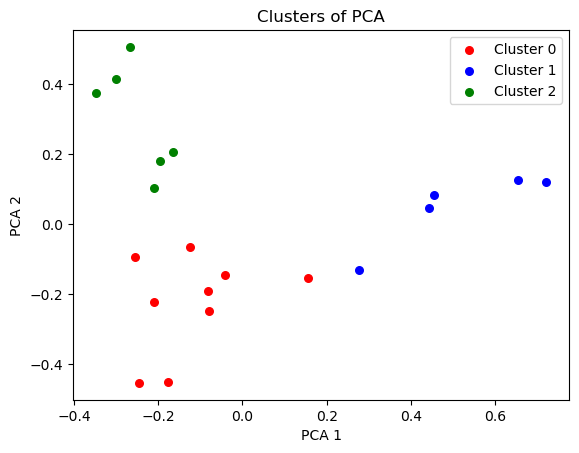

In [26]:
create_pca_graph(cluster_cus_pca, red_cuisine_pca, 3)

We can notice there are 3 clusters of cuisines

In [27]:
# cuisine_df[cluster_cus_pca==0]['cuisine']
# cuisine_df[cluster_cus_pca==1]['cuisine']
# cuisine_df[cluster_cus_pca==2]['cuisine']

**CLUSTER 1: <br>**
> GREEK<br>
> SPANISH<br>
> ITALIAN<br>
> FRENCH<br>
> MOROCCAN<br>
> RUSSIAN<br>

<br><br>
**CLUSTER 2: <br>**
> FILIPINO<br>
> CHINESE<br>
> THAI<br>
> VIETNAMESE<br>
> KOREAN<br>

<br><br>
**CLUSTER 3: <br>**
> SOUTHERN US<br>
> INDIAN<br>
> JAMAICAN<br>
> MEXICAN<br>
> BRITISH<br>
> CAJUN CREOLE<br>
> BRAZILIAN<br>
> JAPANESE<br>
> IRISH<br>

## Creating Actual Clusters 

### NOTE: Don't add cluster for best results. (Skip this section. Move to Model Development)

CPU times: user 24min 6s, sys: 20 s, total: 24min 26s
Wall time: 2min 16s


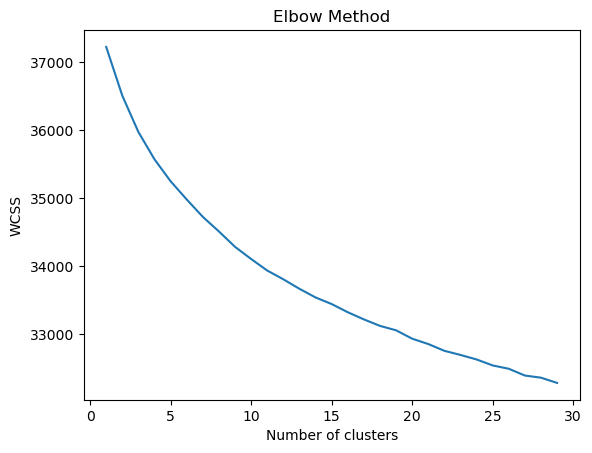

In [28]:
%%time
wcss = get_kmeans_wcss(train_tfidf,30)

WCSS shows number of clusters = 19 can be an apt choice (elbow point)

In [29]:
cluster, km = kmeans(train_tfidf,19) # train_cv or train_tfidf
cluster_test = km.predict(test_tfidf)
cluster

array([ 3,  2, 10, ...,  4, 13,  2], dtype=int32)

In [30]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(cluster.reshape(-1, 1))
cluster_encoded = enc.transform(cluster.reshape(-1, 1)).toarray()

In [31]:
cluster_test_encoded = enc.transform(cluster_test.reshape(-1, 1)).toarray()

### Adding cluster as a feature


In [32]:
train_tfidf_nonsparse = np.append((train_tfidf).toarray(), cluster_encoded, axis=1)

In [33]:
test_tfidf_nonsparse = np.append((test_tfidf).toarray(), cluster_test_encoded, axis=1)

In [34]:
print("TRAINING DATASET: Added cluster of shape {} to train_cv of shape {} as a column".format(cluster_encoded.shape, train_tfidf.shape))
print("TESTING DATASET: Added cluster of shape {} to test_cv of shape {} as a column".format(cluster_test_encoded.shape, test_tfidf.shape))

TRAINING DATASET: Added cluster of shape (39774, 19) to train_cv of shape (39774, 2793) as a column
TESTING DATASET: Added cluster of shape (9944, 19) to test_cv of shape (9944, 2793) as a column


# Model Development

In [35]:
from scipy import sparse

# train = sparse.csr_matrix(train_tfidf_nonsparse)
# test = sparse.csr_matrix(test_tfidf_nonsparse)

train = train_tfidf # USE THIS FOR BEST RESULTS (0.8106)
test = test_tfidf # USE THIS FOR BEST RESULTS (0.8106)

## Linear SVC

In [36]:
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import f1_score

param_grid = {'C': [0.001, 0.1, 1, 10, 50, 100, 500, 1000, 5000],  
              'penalty': ['l1','l2'],
             'loss': ['hinge','squared hinge']} 

grid = GridSearchCV(LinearSVC(), param_grid, refit = True, verbose = 3, n_jobs=-1, scoring='f1_micro')

In [37]:
%%time
grid.fit(train, target) 

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 2/5] END .....C=0.001, loss=hinge, penalty=l1;, score=nan total time=   0.1s
[CV 3/5] END .....C=0.001, loss=hinge, penalty=l1;, score=nan total time=   0.1s
[CV 3/5] END C=0.001, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END C=0.001, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END C=0.001, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 1/5] END .....C=0.001, loss=hinge, penalty=l1;, score=nan total time=   0.3s
[CV 5/5] END C=0.001, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 1/5] END .......C=0

/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END .......C=1, loss=hinge, penalty=l2;, score=0.786 total time=   7.0s


/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END .......C=1, loss=hinge, penalty=l2;, score=0.791 total time=   9.7s


/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END .......C=1, loss=hinge, penalty=l2;, score=0.789 total time=   6.1s
[CV 1/5] END C=50, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END C=50, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END C=50, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END C=50, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END C=50, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END C=50, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 2/5] END C=50, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 3/5] END C=50, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s


/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END .......C=1, loss=hinge, penalty=l2;, score=0.780 total time=   6.8s
[CV 4/5] END C=50, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 5/5] END C=50, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 1/5] END .......C=100, loss=hinge, penalty=l1;, score=nan total time=   0.1s
[CV 2/5] END .......C=100, loss=hinge, penalty=l1;, score=nan total time=   0.1s
[CV 3/5] END .......C=100, loss=hinge, penalty=l1;, score=nan total time=   0.1s
[CV 4/5] END .......C=100, loss=hinge, penalty=l1;, score=nan total time=   0.1s
[CV 5/5] END .......C=100, loss=hinge, penalty=l1;, score=nan total time=   0.1s


/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ......C=10, loss=hinge, penalty=l2;, score=0.784 total time=  10.3s


/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END ......C=10, loss=hinge, penalty=l2;, score=0.777 total time=  10.7s


/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ......C=10, loss=hinge, penalty=l2;, score=0.778 total time=  10.4s


/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END ......C=10, loss=hinge, penalty=l2;, score=0.787 total time=  11.5s
[CV 1/5] END C=100, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END C=100, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END C=100, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END C=100, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END C=100, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END C=100, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 2/5] END C=100, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 3/5] END C=100, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 4/5] END C=100, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 5/5] END C=100, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 1/5] END .......C=500, loss=hinge, penalty=l1;, score=nan total time=   0.1s
[CV 2/5] END .....

/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END ......C=10, loss=hinge, penalty=l2;, score=0.772 total time=  13.9s


/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END ......C=50, loss=hinge, penalty=l2;, score=0.765 total time=  22.5s


/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ......C=50, loss=hinge, penalty=l2;, score=0.773 total time=  23.0s


/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END ......C=50, loss=hinge, penalty=l2;, score=0.756 total time=  23.1s


/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ......C=50, loss=hinge, penalty=l2;, score=0.767 total time=  28.9s
[CV 1/5] END C=500, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END C=500, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END C=500, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END C=500, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END C=500, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END C=500, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 2/5] END C=500, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 3/5] END C=500, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 4/5] END C=500, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 5/5] END C=500, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 1/5] END ......C=1000, loss=hinge, penalty=l1;, score=nan total time=   0.1s
[CV 2/5] END .....

/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END ......C=50, loss=hinge, penalty=l2;, score=0.777 total time=  29.5s


/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END .....C=100, loss=hinge, penalty=l2;, score=0.767 total time=  33.9s


/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END .....C=100, loss=hinge, penalty=l2;, score=0.752 total time=  33.5s


/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END .....C=100, loss=hinge, penalty=l2;, score=0.770 total time=  33.7s


/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END .....C=100, loss=hinge, penalty=l2;, score=0.761 total time=  35.7s
[CV 1/5] END C=1000, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END C=1000, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END C=1000, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END C=1000, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END C=1000, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END C=1000, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 2/5] END C=1000, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 3/5] END C=1000, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 4/5] END C=1000, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 5/5] END C=1000, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 1/5] END ......C=5000, loss=hinge, penalty=l1;, score=nan total time=   0.1s
[CV 2/5]

/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END .....C=100, loss=hinge, penalty=l2;, score=0.757 total time=  46.2s


/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END .....C=500, loss=hinge, penalty=l2;, score=0.747 total time= 1.5min


/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END .....C=500, loss=hinge, penalty=l2;, score=0.745 total time= 1.6min


/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END .....C=500, loss=hinge, penalty=l2;, score=0.750 total time= 1.6min


/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END .....C=500, loss=hinge, penalty=l2;, score=0.752 total time= 2.1min
[CV 1/5] END C=5000, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END C=5000, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END C=5000, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END C=5000, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END C=5000, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END C=5000, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 2/5] END C=5000, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 3/5] END C=5000, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 4/5] END C=5000, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 5/5] END C=5000, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s


/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END .....C=500, loss=hinge, penalty=l2;, score=0.751 total time= 2.0min


/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END ....C=1000, loss=hinge, penalty=l2;, score=0.728 total time= 1.8min
[CV 1/5] END ....C=1000, loss=hinge, penalty=l2;, score=0.730 total time= 2.0min


/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ....C=1000, loss=hinge, penalty=l2;, score=0.736 total time= 2.0min


/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END ....C=1000, loss=hinge, penalty=l2;, score=0.731 total time= 1.9min


/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ....C=5000, loss=hinge, penalty=l2;, score=0.726 total time= 1.8min


/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ....C=1000, loss=hinge, penalty=l2;, score=0.730 total time= 2.1min


/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END ....C=5000, loss=hinge, penalty=l2;, score=0.714 total time= 1.9min


/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ....C=5000, loss=hinge, penalty=l2;, score=0.716 total time= 1.2min
[CV 4/5] END ....C=5000, loss=hinge, penalty=l2;, score=0.665 total time=  59.4s


/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
135 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py", line 274, in fit
    se

[CV 5/5] END ....C=5000, loss=hinge, penalty=l2;, score=0.716 total time=  54.7s
CPU times: user 10 s, sys: 622 ms, total: 10.6 s
Wall time: 3min 13s


/home/reveur/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.001, 0.1, 1, 10, 50, 100, 500, 1000, 5000],
                         'loss': ['hinge', 'squared hinge'],
                         'penalty': ['l1', 'l2']},
             scoring='f1_micro', verbose=3)

In [38]:
grid.best_params_

{'C': 1, 'loss': 'hinge', 'penalty': 'l2'}

In [39]:
grid.best_score_

0.7857395201541484

In [40]:
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC, SVC

def evalfn(C, gamma):
    s = SVC(C=float(C), gamma=float(gamma), kernel='rbf', class_weight='balanced')
    f = cross_val_score(s, train, target, cv=5, scoring='f1_micro')
    return f.max()

In [41]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
new_opt = BayesianOptimization(evalfn, {'C': (0.1, 1000),  
              'gamma': (0.0001, 1)  })

In [42]:
############################################
### OPTIMIZED PARAMETERS ARE SHOWN BELOW ###
##  HYPER PARAMETER OPT IS TIME CONSUMING ##
############################################

# %%time
# new_opt.maximize(n_iter=15, init_points=3)   

In [43]:
# new_opt.max

In [44]:
# OPTIMIZED PARAMETERS
# {'target': 0.7945391461758937,
#  'params': {'C': 604.5300203551828, 'gamma': 0.9656489284085462}}

# With cluster(n=19) as a parameter:
# {'target': 0.7940917661847894,
#  'params': {'C': 509.674609734803, 'gamma': 0.724238238886398}}

C = 604.5300203551828
gamma = 0.9656489284085462

clf = SVC(C=float(C), gamma=float(gamma), kernel='rbf')

In [45]:
%%time
clf.fit(train, target)

CPU times: user 2min 54s, sys: 438 ms, total: 2min 55s
Wall time: 2min 55s


SVC(C=604.5300203551828, gamma=0.9656489284085462)

In [46]:
import pickle
from datetime import datetime

now = datetime.now()
print("MODEL SAVED AT {}".format(now))
model_name = "SVC-whats-cooking-trial-final2-{}.pickle.dat".format(now)
pickle.dump(clf, open(model_name, "wb"))

MODEL SAVED AT 2024-06-25 19:07:54.633585


In [47]:
# clf = pickle.load(open("SVC-whats-cooking-trial-final2-{}.pickle.dat", "rb"))

In [48]:
y_pred = clf.predict(test)

## Submission

In [49]:
my_submission = pd.DataFrame({'id':test_ids})
my_submission['cuisine'] = y_pred
now = datetime.now()
my_submission.to_csv('submission_{}.csv'.format(now), index=False)
print('Saved file to disk as submission_{}.csv.'.format(now))

Saved file to disk as submission_2024-06-25 19:08:40.853098.csv.


# FERTIG